In [1]:
import numpy as np
import pandas as pd
import glob
import os
import sys
import matplotlib.pyplot as plt
import torch
import matplotlib.gridspec as gridspec
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
import pickle
# Usage example:
saved_dataset = '/scratch/tappay01/custom_dataset2.pkl'
#with open(saved_dataset, 'wb') as file:
#    pickle.dump(combined_dataset, file)
#Later, when you want to use the dataset again, you can load it from the file
with open(saved_dataset, 'rb') as file:
   combined_dataset = pickle.load(file)

In [3]:
BATCH_SIZE = 32 #To be 32 according to paper

In [4]:
from torch.utils.data import ConcatDataset, random_split
from torch.utils.data import DataLoader

print('Total data :',len(combined_dataset))
# Split combined dataset into train, validation, and test
train_size = int(0.8 * len(combined_dataset))
valid_size = int(0.1 * len(combined_dataset))
test_size = len(combined_dataset) - (train_size + valid_size)

train_subset, val_subset, test_subset = random_split(combined_dataset, [train_size, valid_size, test_size])

# Turn train, val and test custom Dataset into DataLoader's
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8) #creates 8 worker processes to load the data in parallel. 
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

print("Total number of samples in the train dataset:", len(train_subset))
print("Number of batches:", len(train_loader))
print("Total number of samples in the validation dataset:", len(val_subset))
print("Number of batches:", len(val_loader))
print("Total number of samples in the test dataset:", len(test_subset))
print("Number of batches:", len(test_loader))

Total data : 1042


Total number of samples in the train dataset: 833
Number of batches: 27
Total number of samples in the validation dataset: 104
Number of batches: 4
Total number of samples in the test dataset: 105
Number of batches: 4


In [23]:
# Get one batch from the loader
data_batch, condition_batch, water_batch, density_batch, data_name_batch = next(iter(train_loader))

# Print the shapes
print("Data batch shape:", data_batch.shape)
print("Condition batch shape:", condition_batch.shape)
print("Water batch shape:", water_batch.shape)
print("Density batch shape:", density_batch.shape)
print("Data name batch shape:", len(data_name_batch))

Data batch shape: torch.Size([32, 1, 16, 16, 128])
Condition batch shape: torch.Size([32, 2, 16, 16, 128])
Water batch shape: torch.Size([32, 1, 16, 16, 128])
Density batch shape: torch.Size([32, 1, 16, 16, 128])
Data name batch shape: 32


 Check if I correctly transformed the energies to dose is to calculate the sum of all doses in voxels of one water-image and compare it to the sum of all doses in voxels of the corresponding phantom-image. Since in either case the Carbon beam gets fully absorbed, the doses should be relatively equal.

!No. ???


In [6]:
for i in range(0,32):
    data_sample = data_batch[i, 0]
    print('data sample ', data_sample.shape, torch.min(data_sample).item(),  torch.max(data_sample).item())
for i in range(0,32):
    water_sample = water_batch[i, 0]
    print('water sample ',water_sample.shape, torch.min(water_sample).item(), torch.max(water_sample).item())

data sample  torch.Size([16, 16, 128]) 0.0 0.285074383020401
data sample  torch.Size([16, 16, 128]) 0.0 0.42716386914253235
data sample  torch.Size([16, 16, 128]) 0.0 0.3079935908317566
data sample  torch.Size([16, 16, 128]) 0.0 0.26081764698028564
data sample  torch.Size([16, 16, 128]) 0.0 0.10739538073539734
data sample  torch.Size([16, 16, 128]) 0.0 0.12432551383972168
data sample  torch.Size([16, 16, 128]) 0.0 0.9106773138046265
data sample  torch.Size([16, 16, 128]) 0.0 0.24870456755161285
data sample  torch.Size([16, 16, 128]) 0.0 0.25354310870170593
data sample  torch.Size([16, 16, 128]) 0.0 0.25339755415916443
data sample  torch.Size([16, 16, 128]) 0.0 0.611115038394928
data sample  torch.Size([16, 16, 128]) 0.0 0.2302691638469696
data sample  torch.Size([16, 16, 128]) 0.0 0.8895567059516907
data sample  torch.Size([16, 16, 128]) 0.0 0.24412620067596436
data sample  torch.Size([16, 16, 128]) 0.0 0.33644193410873413
data sample  torch.Size([16, 16, 128]) 0.0 0.5797207355499268
d

In [24]:
data_sample = data_batch[0, 0]
filename = data_name_batch[0]
filename

'Data4_2250MeV_-25Mm_-71.5Mm.npy'

In [8]:
import numpy as np 
watersim = np.load("/scratch/tappay01/watersimulation/DATASET/DATASET_4000MeV.npy")
print(watersim.shape)
max_index = np.unravel_index(watersim.argmax(), watersim.shape)
print(max_index)


(160, 283, 283)
(80, 141, 208)


In [116]:
import torch.nn as nn
import torch
from torchinfo import summary
import torch.nn.functional as F


class Block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv3d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_c)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv3d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_c)
        self.silu = nn.SiLU()
        self.dropout = nn.Dropout3d(p=0.15)

    def forward(self, x):
        return self.dropout(self.silu(self.bn2(self.conv2(self.silu(self.bn1(self.conv1(x)))))))
    
       

class Encoder(nn.Module):
    def __init__(self, channels=(2, 16, 32, 64)):
        super().__init__()
        self.enc_block = nn.ModuleList(
            [Block(channels[i], channels[i+1])
                for i in range(len(channels) - 1)])
        self.pool = nn.MaxPool3d((2,2, 2))

    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        block_outputs = []

        # loop through the encoder blocks
        for block in self.enc_block:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
            x = block(x)
            block_outputs.append(x)
            x = self.pool(x)
		# return the list containing the intermediate outputs
        return x, block_outputs


class Decoder(nn.Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        self.channels = channels
        self.up = nn.ModuleList(
			[nn.ConvTranspose3d(channels[i], channels[i + 1], kernel_size=2, stride=2, padding=0)
			 	for i in range(len(channels) - 1)])
        self.dec_blocks = nn.ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
    def forward(self, x, encFeatures):
		# loop through the number of channels
        for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
            x = self.up[i](x)
            #print('x',x.shape)
			# crop the current features from the encoder blocks,
            encFeat = self.crop(encFeatures[i], x)
            #print('encFeat',encFeat.shape)
			# concatenate them with the current upsampled features,
            x = torch.cat([x, encFeat], dim=1)
			# and pass the concatenated output through the current decoder block
            x = self.dec_blocks[i](x)
		# return the final decoder output
        return x
    
    def crop(self, encFeatures, x):
        # Grab the dimensions of the inputs and crop the encoder features
        # to match the spatial dimensions of x (H, W).
        (_, _, D, H, W) = x.shape

        # crop the center region, calculate the starting indices for cropping as follows:
        start_d = (encFeatures.shape[2] - D) // 2
        start_h = (encFeatures.shape[3] - H) // 2
        start_w = (encFeatures.shape[4] - W) // 2

        # Crop the encoder features using PyTorch's slicing operations.
        cropped_features = encFeatures[:, :, start_d:start_d+D, start_h:start_h+H, start_w:start_w+W]

        # Return the cropped features
        return cropped_features




class Generator(nn.Module):
    def __init__(self, encChannels=(2, 16, 32, 64), decChannels=(64, 32, 16), nbClasses=1, retainDim=True, outSize=(16,16,128)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        # initialize the regression head for 3D output
        self.head = nn.Conv3d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
        # grab the features from the encoder
        b, enc_features = self.encoder(x)
        #print('after encoder b ',b.shape)
        #print('after encoder enc_features ', enc_features[::-1][0].shape)
        dec_features = self.decoder(b, enc_features[::-1][1:])
        print("dec_features",dec_features)
        output = self.head(dec_features)
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            output = F.interpolate(output, self.outSize, mode='trilinear', align_corners=False)
        # Apply sigmoid activation to constrain values between 0 and 1
        output = torch.sigmoid(output)
        return output

In [117]:
import torch
from utils import plot_slice
#from model import Generator  # Import your Generator class

# Assuming you have set dimensions and batch size
batch_size = 32  # example batch size
depth, height, width = 2, 2, 16  # example dimensions

# Initialize your model
model = Generator()
model.eval()  # Set the model to evaluation mode

num_tests = 5  # Number of different noise vectors to test
for i in range(num_tests):

    # Generate noise
    random_input = torch.randn(1, 2, 16, 16, 128)
    # Run the model with the same input data and new random noise
    output = model(random_input)
    
    # Analyze the output
    # You can visualize or print summary statistics of the output
    print(f"Test {i+1}: Output Summary - {output.mean()}, {output.std()}")

    # Optionally, save or display the output for further comparison


Test 1: Output Summary - 0.5507583022117615, 0.00039803635445423424
Test 2: Output Summary - 0.5507375597953796, 0.000417951843701303
Test 3: Output Summary - 0.5507542490959167, 0.0004212244530208409
Test 4: Output Summary - 0.5507474541664124, 0.000403262471081689
Test 5: Output Summary - 0.5507720708847046, 0.0004191685584373772


In [118]:
output.shape

torch.Size([1, 1, 16, 16, 128])

In [119]:
# Check the output
print(output)

tensor([[[[[0.5508, 0.5509, 0.5511,  ..., 0.5512, 0.5501, 0.5495],
           [0.5508, 0.5509, 0.5510,  ..., 0.5511, 0.5501, 0.5496],
           [0.5510, 0.5510, 0.5510,  ..., 0.5509, 0.5503, 0.5500],
           ...,
           [0.5511, 0.5511, 0.5512,  ..., 0.5506, 0.5504, 0.5503],
           [0.5508, 0.5507, 0.5506,  ..., 0.5504, 0.5502, 0.5501],
           [0.5506, 0.5505, 0.5503,  ..., 0.5502, 0.5501, 0.5500]],

          [[0.5507, 0.5508, 0.5511,  ..., 0.5513, 0.5504, 0.5500],
           [0.5509, 0.5509, 0.5510,  ..., 0.5512, 0.5505, 0.5501],
           [0.5511, 0.5510, 0.5510,  ..., 0.5510, 0.5506, 0.5504],
           ...,
           [0.5508, 0.5509, 0.5511,  ..., 0.5507, 0.5505, 0.5504],
           [0.5505, 0.5505, 0.5505,  ..., 0.5504, 0.5503, 0.5502],
           [0.5503, 0.5503, 0.5502,  ..., 0.5502, 0.5502, 0.5502]],

          [[0.5507, 0.5508, 0.5510,  ..., 0.5515, 0.5512, 0.5511],
           [0.5509, 0.5509, 0.5510,  ..., 0.5514, 0.5512, 0.5511],
           [0.5513, 0.5512

/tmp/ipykernel_207404/3402539139.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


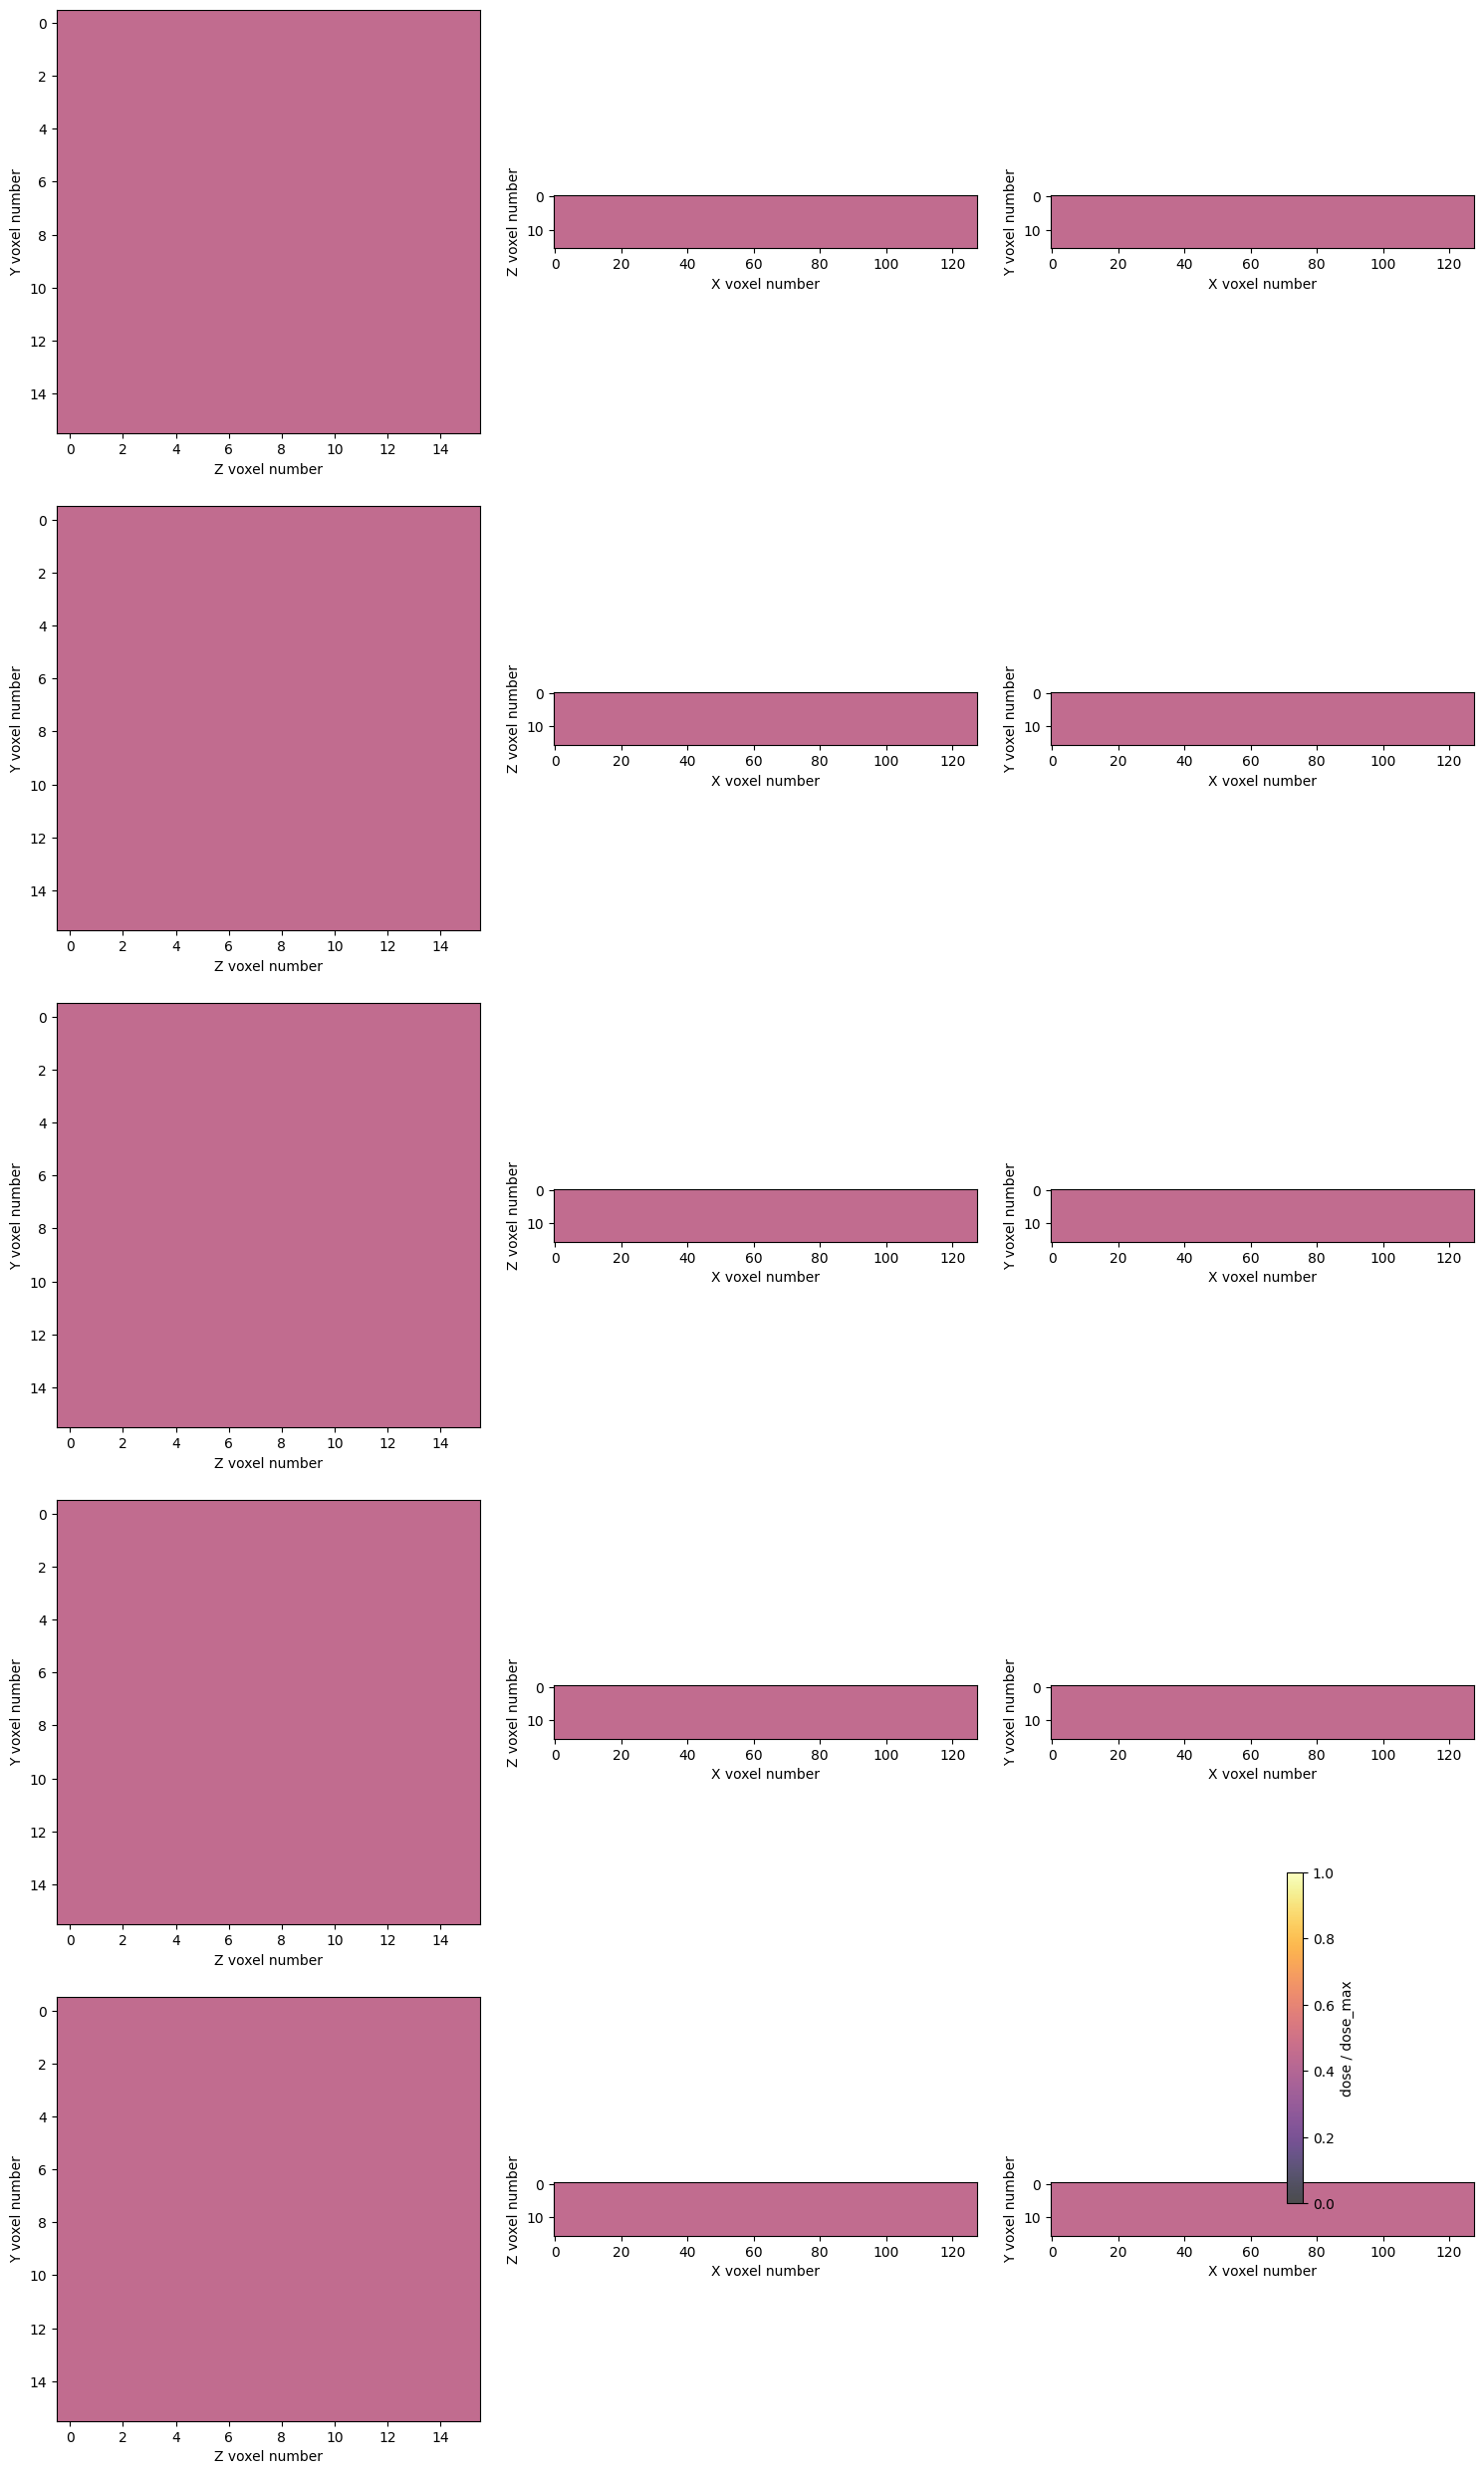

In [114]:

n=5
# Common settings for colormap
colormap_setting = {'cmap': 'inferno', 'alpha': 0.7, 'vmin': 0, 'vmax': 1}


# Plot for real data
fig, axs = plt.subplots(n, 3, figsize=(15, 5 * n))

for i in range(n):
    data_sample = output.squeeze().detach().numpy()[i]
    density_sample = density_batch.squeeze().detach().numpy()[i]

    # ZY plane
    axs[i, 0].imshow(data_sample[:, :, 7], **colormap_setting)
    axs[i, 0].set_xlabel('Z voxel number')
    axs[i, 0].set_ylabel('Y voxel number')

    # ZX plane
    axs[i, 1].imshow(data_sample[:, 7, :], **colormap_setting)
    axs[i, 1].set_xlabel('X voxel number')
    axs[i, 1].set_ylabel('Z voxel number')

    # YX plane
    img_data = axs[i, 2].imshow(data_sample[7, :, :], **colormap_setting)
    axs[i, 2].set_xlabel('X voxel number')
    axs[i, 2].set_ylabel('Y voxel number')

    # Add colorbar only on the last row
    if i == n - 1:
        fig.colorbar(img_data, ax=axs[i, :], fraction=0.046, pad=0.04).set_label('dose / dose_max')

plt.tight_layout()
plt.show() 
